# Anonymization of health care data

Health information is widely acknowledged to be sensitive personal information. Information of this type may contain facts about an individual that can be used by insurance companies, future employers or others against the benefit of the person involved. For this reason, in many countries and jurisdictions, gathering, storing and publishing such data by third parties is limited by laws and regulations. In general, the gist of this type of legislation is twofold. For a third party to be allowed to process health data, either:

* the person the information is about has given permission for usage
* the data is changed in such a way that it is not possible to determine the identity of the individual


Although health data is sensitive in the sense described above, large health datasets can offer a wealth of information to scientists and researchers, for example in determining the effects of specific medication or finding correlations between lifestyle and disease. However, datasets with this type of information may not be used without satisfying either of the conditions mentioned.

Especially for large existing datasets, it can be very difficult, if not completely infeasible, to obtain permission from each individual in the dataset. In order to use this data without jeopardizing an individuals privacy and stay within legal boundaries, the data needs to be changed in such a way that it is impossible to determine the identity of individual the information is about. This process is commonly referred to as **anonymization**.

A common solution for anonymization is simply removing all values from the dataset that identify a person directly, e.g. remove a person's name and SSI. Sometimes a variant known as pseudonimization is used, where this information is not removed, but replaced by a specific ID number. This ID number can only be traced back to the person involved through a Trusted Third Party (TTP)

Depending on context, these methods have advantages and disadvantages. One important observation however, is that very often the second condition is not adequately satisfied: it is still possible to infer the identity of the person involved from the given data.

Consider the following (hypothetical) example of an anonymized dataset published by Dr Bob for medical research.

![jupyter](example.png)

At first glance, no identifiable information has been leaked in this dataset: no names are published and the amount of information is limited. However, suppose you see the following person walk out of Dr. Bob's practice:

You can recognize several characteristics about this person:

* She is a woman
* She is quite young (at least younger than 20 by estimation)
* She has an occupation as chef or baker (or something that requires similar attire)

While any of these characteristics by themselves would match multiple records in the dataset, there's only one record that satisfies all three. Therefore we can learn the medical condition of this person and Dr. Bob has revealed personal information about one of his patients.

Of course, in this example re-identifying a person is quite easy, because the dataset is relatively small. In a larger dataset, one could argue, more young, female chefs might be included, making it more difficult or even impossible to determine the exact record in the dataset depicting the person from the photo.

This argument makes sense; a real-world dataset would probably contain many more records than the example. However, such a real-world dataset usually also contains many more columns (i.e. more data per record). It's not difficult to see that more data increases the risk of re-identification again. Furthermore, many people may be indistinguishable (or equivalent) within the dataset, but some records will still have a unique combination of values. As an example, someone with a very uncommon profession and being above 100 years old is still easily re-identified in most large datasets.

How can we mitigate this type of risk? We could leave out many of the columns, but this would destroy most of the analytical value in the data, which defeats the purpose of releasing the data in the first place. A better solution would leave out as much data as needed to prevent re-identification, but not more. Such a solution would allow us to retain analytical value as much as possible, while respecting privacy for subjects involved. The trade-off we seek to optimize can be depicted a follows:

![jupyter](example2.png)

The solution for the problem described above: make sure that every record has at least one equivalent record, i.e. a record that contains the same values on all properties that are publicly known or easy to determine.

# k-anonymity

The concept of k-anonymity is used to express the level of privacy in a dataset. In a dataset that was de-identified following a k-anonymity algorithm, all records are equivalent to one or more other records, creating a group of equivalent records, or equivalence class. The size of the smallest of these groups in a dataset is the value of k.

See for example an adapted version of the table above:

![jupyter](example3.png)

When we ignore the (presumably not publicly known) _Medical condition_ column, every record in the table above has at least one duplicate. The smallest set of equivalent records (i.e. the smallest equivalence class) in this table has size two (e.g. the set Male/50+/Yes). Thus this table can be considered 2-anonymous. Note that real-world values for _k_ are usually a lot larger.

# How to achieve k-anonymity

Looking at the table above, we can observe the changes that made this dataset reach the 2-anonymity level:

* One record was completely suppressed
* The age value for each record was classified into one of two categories: 50- or 50+
* The occupation value for each record was generalized into Yes or No

These observations show two common techniques regularly used in combination to achieve a certain level of anonymity:

* Suppression: leaving out records that have a very unique combination of attribute values
* Generalization: making values more generic, so that more records share the same value

In applying these techniques, decisions have to be made about which records to suppress and to what extent the columns should be generalized. These decisions can depend on the purpose the dataset is released for: age may be a relevant variable in some scientific studies, but less so in others. Very often however, datasets are released for a general purpose or the purpose may be difficult to obtain. In these cases, algorithms may be used that try to reach k-anonymity with the least amount of suppression and generalization possible. These algorithms typically involve trying a lot of combinations of generalization levels and suppression criteria, before an optimal solution is chosen.

# Implementing k-anonymity

In this notebook, we'll explore data anonymization, in particular "k-anonymity" [1]. We will implement a simple algorithm [2] to produce a k-anonymous dataset.

For more reading on the topic, please see: 

- [k-Anonymity: A Model For Protecting Privacy. Latanya Sweeney](https://epic.org/privacy/reidentification/Sweeney_Article.pdf)
- [Mondrian - Multidimensional k-Anonymity](https://www.utdallas.edu/~muratk/courses/privacy08f_files/MultiDim.pdf)

Turning a dataset into a k-anonymous (and possibly l-diverse or t-close) dataset is a complex problem, and finding the optimal partition into k-anonymous groups is an NP-hard problem. Fortunately, several practical algorithms exists that often produce "good enough" results by employing greedy search techniques.

In this tutorial we will explore the so-called "Mondrian" algorithm (see link above), which uses a greedy search algorithm to parition the original data into smaller and smaller groups (if we plot the resulting partition boundaries in 2D they resemble the pictures by Piet Mondrian, hence the name).

The algorithm assumes that we have converted all attributes into numerical or categorical values and that we're able to measure the "span" of a given data attribute $X_i$ (we'll explain that in more detail later).

### Partitioning

The algorithm proceeds then as follows to partition the data into k-anonymous gorups:

1. Initialize the finished set of partitions to an empty set $P_{finished} = \{\}$.
2. Initialize the working set of paritions to a set containing a partition with the entire dataset $P_{working} = \{\{1, 2,\dots ,N\}\}$.
4. While there are partitions in the working set, pop one partition from it and
  * Calculate the relative spans of all columns in the partition.
  * Sort the resulting columns by their span (in descending order) and iterate over them. For each column,
      * Try to split the partition along that column using the median of the column values as the split point.
      * Check if the resulting partitions are valid according to our k-anonymity (and possibly additional) criteria.
      * If yes, add the two new partitions to the working set and break out of the loop.
  * If no column produced a valid split, add the original partition to the set of finished partitions.
5. Return the finished set of partitions

### Data Aggregation

After obtaining the partitions we still need to aggregate the values of the quasi identifiers and the sensitive attributes in each k-anonymous group. For this, we can e.g. replace numerical attributes with their range (e.g. "age: 24-28") and categorical attributes with their union (e.g. "employment-group: [self-employed, employee, worker]"), though other aggregations are possible. Methods like [Anatomy](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.156.9150&rep=rep1&type=pdf) even preserve the micro-data in each group, which increases re-identification risk though.

## Usage of the Anonymized Data

We can then use the anonymized data for privacy-preserving machine learning, e.g. using scikit-learn. If we have time at the end of this part we'll cover this as well. With the dataset generation method discussed here you can use the resulting datasets just as you would use a normal dataset though, so there's really nothing special about the anonymized data here.

Let's get started with the anonymization!

In [1]:
# we use Pandas to work with the data as it makes working with categorical data very easy
import pandas as pd

In [2]:
# this is a list of the column names in our dataset (as the file doesn't contain any headers)
names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

# some fields are categorical and will require special treatment
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
#Load the dataset for this exercise
### YOUR CODE HERE
###
df = pd.read_csv("K-Anonymity-master/data/k-anonymity/adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [3]:
df.head()#Take a look of our dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


In [4]:
for name in categorical:
    df[name] = df[name].astype('category')

**Implement a function that returns the spans (max-min for numerical columns, number of different values for categorical columns) of all columns for a partition of a dataframe.** 

In [11]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for col in df.columns:
        if col in categorical:
            spans[col] = len(df[col].unique())
        else:
            spans[col] = df[col].max() - df[col].min()
    return spans

In [12]:
full_spans = get_spans(df, df.index)
full_spans

{'age': 73,
 'workclass': 9,
 'fnlwgt': 1478115,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

The answer should be like this:
{'age': 73,
 'workclass': 9,
 'fnlwgt': 1478115,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

**Implement a `split` function that takes a dataframe, partition and column and returns two partitions that split the given partition such that all rows with values of the column `column` below the median are in one partition and all rows with values above or equal to the median are in the other.**

In [13]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:   
        #calculate the median of dfp and return 2 dataframe based on the median value
        ### YOUR CODE HERE
        ###
        median = dfp.median()
        dfl = dfp[dfp <= median].values
        dfr = dfp[dfp > median].values
        return (dfl, dfr)

In [27]:
split(df, range(2,80), 'age')

(array([28, 37, 31, 37, 30, 23, 32, 34, 25, 32, 35, 19, 23, 20, 30, 22, 21,
        19, 31, 31, 24, 25, 29, 25, 18, 35, 30, 30, 32, 29, 36, 28, 25, 19,
        31, 29, 23, 27, 18, 31], dtype=int64),
 array([38, 53, 49, 52, 42, 40, 38, 43, 40, 54, 43, 59, 56, 54, 39, 49, 45,
        48, 48, 53, 49, 57, 53, 44, 41, 47, 50, 47, 43, 46, 41, 48, 42, 53,
        49, 79, 40, 67], dtype=int64))

Now that we have all helper functions in place, we can implement the partition algorithm discussed above:

**Implement the partitioning algorithm discussed above, using a k-anonymous criterion for the partitions you create.**

In [29]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    #Check the criterion for the partitions you create(hint: length of partition)
    ### YOUR CODE HERE
    ###
    if df[sensitive_column][partition[0]].shape[0] < k or df[sensitive_column][partition[1]].shape[0]:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        #get the first row from partitions and get the span of it(hint: use the function you have built)
        ### YOUR CODE HERE
        ###
        spans = get_spans(df, partitions, scale) ##bruh
        
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            #Split the specific area based on the rows and columns(hint: use the function you have built)
            ### YOUR CODE HERE
            ###
            
            
            #do I need to put something here?
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            #Add the finished partitions to the finished_partitions
            ### YOUR CODE HERE
            ###
            
            s
    return finished_partitions

Now let's try this on our dataset! To keep things simple, we will at first select only two columns from the dataset that we apply the partitioning to. This makes it easier to check/visualize the result and speed up the execution (the naive algorithm can take several minutes when running on the entire dataset) 

In [30]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

NameError: name 'lp' is not defined

In [22]:
# we get the number of partitions that were created
### YOUR CODE HERE
###

500

Let's visualize the created partitions! To do that, we will write functions to get the rectangular bounds of a partition along two columns. We can then plot these rects to see how our partitioning function divides the dataset. If we perform the partition only along the two columns selected for plotting then the resulting rects should not overlap and cover the entire dataset.

In [24]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [25]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [26]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [27]:
# let's see how our rects look like
rects[:10]

[((17.0, 7.0), (18.0, 9.0)),
 ((18.0, 7.0), (20.0, 9.0)),
 ((21.0, 10.0), (22.0, 11.0)),
 ((25.0, 10.0), (27.0, 11.0)),
 ((37.0, 9.0), (39.0, 10.0)),
 ((37.0, 10.0), (38.0, 13.0)),
 ((41.0, 10.0), (43.0, 13.0)),
 ((39.0, 13.0), (41.0, 16.0)),
 ((46.0, 10.0), (48.0, 13.0)),
 ((46.0, 13.0), (48.0, 16.0))]

In [28]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

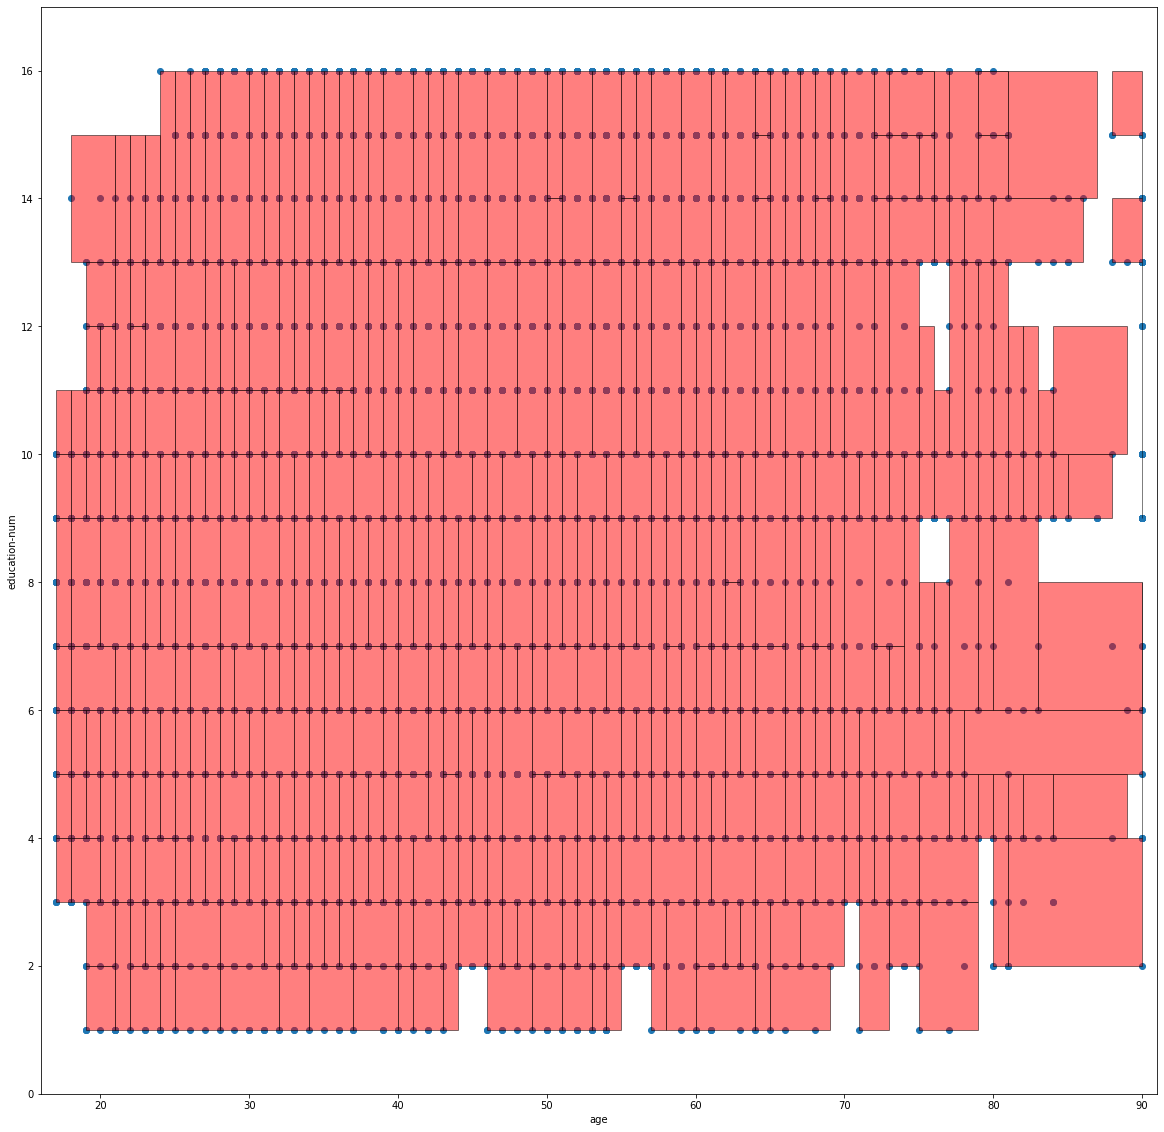

In [29]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

# Generating an k-Anonymous Dataset

Of course, to use the data we want to produce a new dataset that contains one row for each partition and value of the sensitive attribute. To do this, we need to aggregate the columns in each partition.  Let's do this!

In [30]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [34]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    """
    :param               df: The dataframe to be partitioned.
    :param        partition: The partition of the dataframe to check.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param   max_partitions: The maximun partitions value you want
    :returns               : The dataframe which has already been anonymized
    """
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        #To count how many rows we have in each group based on our sensitive column
        ### YOUR CODE HERE
        ###
        values = {}
        for name,val in grouped_columns.items():
            values[name] = val[0]
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [35]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [36]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
### YOUR CODE HERE
###

,age,education-num,income,count
469,17.0,3.000000,<=50k,3
615,17.0,4.000000,<=50k,5
110,17.0,5.000000,<=50k,36
111,17.0,6.000000,<=50k,198
0,17.0,7.200599,<=50k,334
...,...,...,...,...
746,90.0,9.000000,>50k,4
750,90.0,10.545455,<=50k,9
751,90.0,10.545455,>50k,2
818,90.0,14.000000,<=50k,2
